<a href="https://colab.research.google.com/github/r2klabs/CS430Repository/blob/main/EnsembleLearningAndRandomForests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Classification




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Imports for Ensemble Learning and Random Forests


In [3]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

## Other Classifiers

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Imports for Splitting Data and Building Pipeline


In [5]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [6]:
from sklearn import set_config
set_config(display='diagram')

# Imports for Performance Measures

In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report


## Confusion Matrix Function
This function is for creating a graphical version of the confusion matrix.



In [8]:
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    fig = plt.figure(figsize=(10,10))
    heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')

### Evaluate Classification Model
In order to streamline model evaluation, this function callse the plot_cm function and then prints out the Precision, Recall and F1 scores so this doesn't need to be done separately.

In [9]:
def eval_clf_model(y_test, y_pred):
  plot_cm(y_test,y_pred)
  print("Precision: ", precision_score(y_test,y_pred))  
  print("Recall:", recall_score(y_test,y_pred))
  print("F1 Score:", f1_score(y_test,y_pred)) 

## Acquire Data

I won't visualize this data here; I have already done that in previous notebooks.

In [10]:
df = pd.read_csv('/content/gdrive/MyDrive/CS430/original_census.csv')

In [11]:
df.head()

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,state_gov,77516,bachelors,never_married,adm_clerical,not_in_family,white,male,2174,0,40,united_states,<=50K
1,50,self_emp_not_inc,83311,bachelors,married_civ_spouse,exec_managerial,husband,white,male,0,0,13,united_states,<=50K
2,38,private,215646,hs_grad,divorced,handlers_cleaners,not_in_family,white,male,0,0,40,united_states,<=50K
3,53,private,234721,11th,married_civ_spouse,handlers_cleaners,husband,black,male,0,0,40,united_states,<=50K
4,28,private,338409,bachelors,married_civ_spouse,prof_specialty,wife,black,female,0,0,40,cuba,<=50K


### Splitting Data into Train/Test

In [12]:
df['salary'].replace("<=50K", 0, inplace=True)
df['salary'].replace(">50K", 1, inplace=True)

In [13]:
X = df.iloc[:,0:-1]
y = df[['salary']]

### Building the Pipeline


We'll set up our lists to contain the columns that numerical vs categorical.

In [14]:
num_attribs = ['age','fnlwgt','capital_gain','capital_loss', 'hours_per_week']
cat_attribs = ['workclass','education','marital_status','occupation','relationship','race','sex','native_country']

Let's transform the categorical variables **before** we do the train/test split.

In [19]:
transformed_X = pd.get_dummies(X, columns=cat_attribs)
X_train, X_test, y_train, y_test = train_test_split(transformed_X,y, test_size=.20, random_state=32)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(transformed_X,y, test_size=.20, random_state=32)

Now we'll set up the column transformer to only minmax scale.  We are using remainder passthrough because we don't want to apply minmax to categorical variables.

In [22]:
col_transform = ColumnTransformer(transformers=[
                                 ('num',MinMaxScaler(), num_attribs)],
                                  remainder='passthrough')

## Voting Classifier
With these types of classifiers, you classify the data using different alogrithms and then assign it to the majority vote.  For example, it two classifiers vote 0 and one classifier votes 1, then the instance is predicted as class 0. You can use any classifier you want in a voting classifier. Here I will use KNN, Logistic Regression, and Support Vector Machines.


In [22]:
knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(max_iter=100000)
svc = SVC(kernel='rbf')

In [28]:
voting = Pipeline([
                     ('transform', col_transform),
                     ('voting_ensemble',VotingClassifier(
                         estimators=[
                                     ('knn',knn),
                                     ('lr',lr),
                                     ('svc',svc)
                                     ], voting='hard'))
                     ])

### Executing the Model

In [29]:
voting.fit(X_train,np.ravel(y_train))

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['age', 'fnlwgt',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week'])])),
                ('voting_ensemble',
                 VotingClassifier(estimators=[('knn',
                                               KNeighborsClassifier(n_neighbors=3)),
                                              ('lr',
                                               LogisticRegression(max_iter=100000)),
                                              ('svc', SVC())]))])

### Evaluating Model

In [30]:
y_pred = voting.predict(X_test)

Precision:  0.7173174872665535
Recall: 0.5544619422572179
F1 Score: 0.6254626202812732


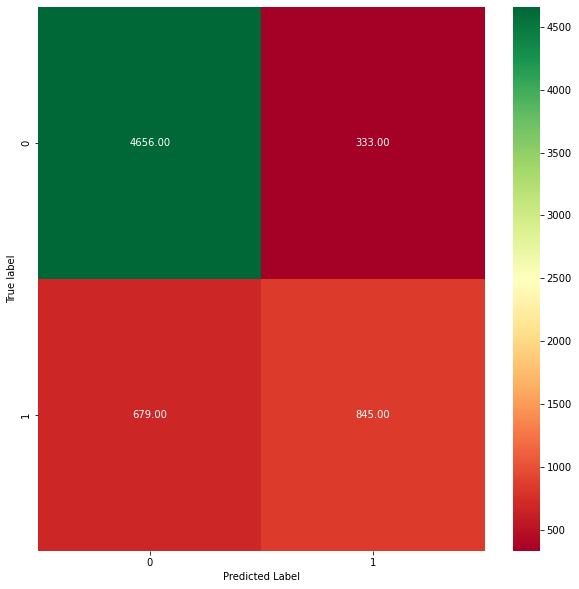

In [32]:
eval_clf_model(y_test,y_pred)

### Conclusion
This model isn't great with this data, but there is a lot of room for trying different parameters of the machine learning algorithms to get better results. You might even try a GridSearch.  I'll leave that up to you to tinker with.

## Bagging and pasting
Another approach is to use the same algorithm multiple times and average the predictions.  That's what bagging and pasting does.

In [33]:
bagging = Pipeline([
                     ('transform', col_transform),
                     ('bagging',BaggingClassifier(DecisionTreeClassifier(),n_estimators=1000, max_samples=5000, bootstrap=True, n_jobs=-1))
                     ])

### Executing the Model

In [34]:
bagging.fit(X_train,np.ravel(y_train))

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['age', 'fnlwgt',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week'])])),
                ('bagging',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                   max_samples=5000, n_estimators=1000,
                                   n_jobs=-1))])

### Evaluating Model

In [35]:
y_pred = bagging.predict(X_test)

Precision:  0.7635189669087974
Recall: 0.6207349081364829
F1 Score: 0.6847629388346


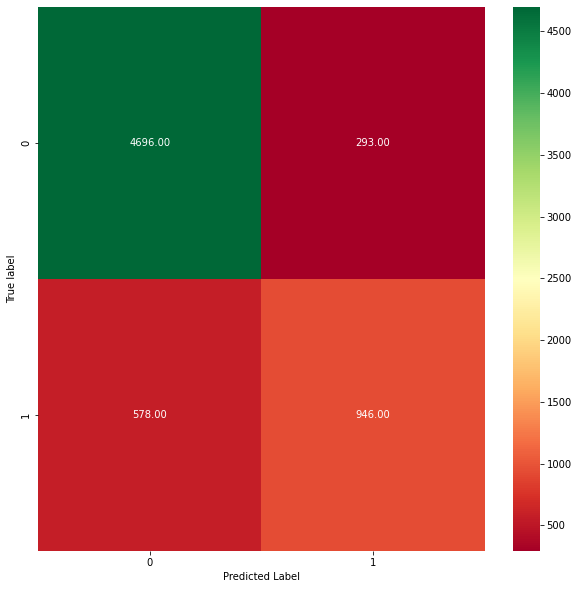

In [36]:
eval_clf_model(y_test,y_pred)

### Conclusion
This model is an improvement over voting; there is also room for trying different parameters for the number of estimators and your decision tree itself.

## Random Forest
This ensemble method works specifically with decision trees. It is essentially the same as using a BaggingClassifier with a DecisionTree. The convenience is the syntax is a little shorter; the results should be the same.

In [23]:
random_forest = Pipeline([
                     ('transform', col_transform),
                     ('rf',RandomForestClassifier(n_estimators=1000, max_samples=5000, bootstrap=True, n_jobs=-1))
                     ])

In [39]:
random_forest.fit(X_train,np.ravel(y_train))

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['age', 'fnlwgt',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week'])])),
                ('rf',
                 RandomForestClassifier(max_samples=5000, n_estimators=1000,
                                        n_jobs=-1))])

### Evaluating Model

In [40]:
y_pred = random_forest.predict(X_test)

Precision:  0.7630104083266613
Recall: 0.6253280839895013
F1 Score: 0.6873422286332493


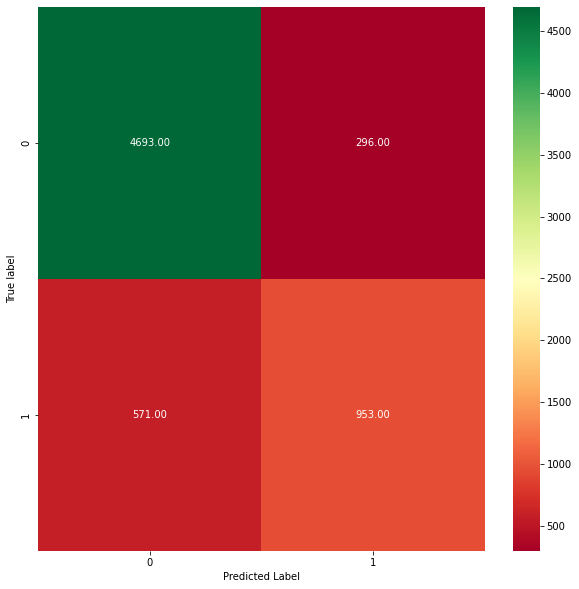

In [41]:
eval_clf_model(y_test,y_pred)

A nice feature of random forests is that you can get a list of the feature importance to the model. In the code below you see the numerical features hold the greatest weights with **age** at the top.

In [50]:
names = random_forest[:-1].get_feature_names_out()
for name, score in zip(names,random_forest.named_steps.rf.feature_importances_):
  print(name, score)

In [52]:
for name, score in zip(names,random_forest.named_steps.rf.feature_importances_):
  print(name, score)

num__age 0.14442365589355954
num__fnlwgt 0.1383923098369496
num__capital_gain 0.09119676071671387
num__capital_loss 0.029165335508370843
num__hours_per_week 0.08496265518297268
remainder__workclass_federal_gov 0.006066577082426734
remainder__workclass_local_gov 0.006952269566486426
remainder__workclass_never_worked 4.323186880062804e-06
remainder__workclass_private 0.013220185966827882
remainder__workclass_self_emp_inc 0.007317108929091193
remainder__workclass_self_emp_not_inc 0.010209133083733692
remainder__workclass_state_gov 0.005453843899962669
remainder__workclass_unknown 0.0025156629119428516
remainder__workclass_without_pay 5.407513631328019e-05
remainder__education_10th 0.0033384990621810468
remainder__education_11th 0.00370878675956238
remainder__education_12th 0.0013940264167004407
remainder__education_1st_4th 0.0004608321444577445
remainder__education_5th_6th 0.0013955173706876173
remainder__education_7th_8th 0.004152953760034777
remainder__education_9th 0.002248770063335944

### Conclusion
This model is an improvement over voting and the same for bagging; there is also room for trying different parameters for the number of estimators and number of samples.

#### A quick diversion
Since RandomForest ranks the feature importance, I wonder if we just drop the categorical features and run the model if we would see any difference. I am going to do this next. If I remove the column transformer, that should do the trick.

In [60]:
random_forest2 = Pipeline([
                          ('rf',RandomForestClassifier(n_estimators=1000, max_samples=5000, bootstrap=True, n_jobs=-1))
                     ])

random_forest2.fit(X_train, np.ravel(y_train))
y_pred = random_forest2.predict(X_test)

Precision:  0.6194225721784777
Recall: 0.7582329317269076
F1 Score: 0.6818345973275551


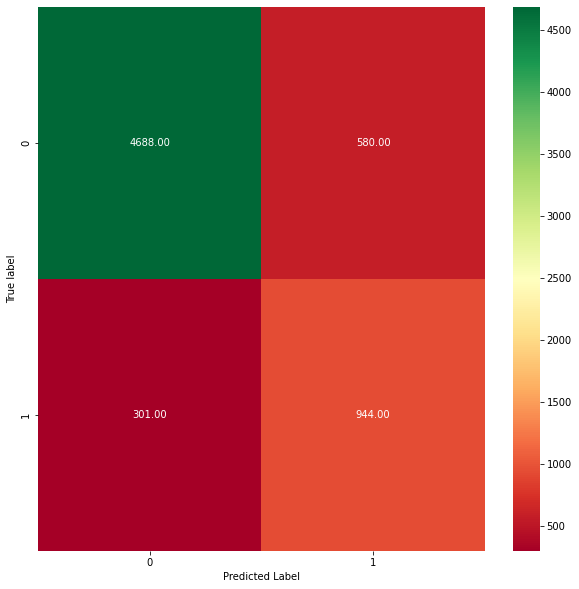

In [61]:
eval_clf_model(y_pred, y_test)

Precision and Recall flipped scores, but the F1 score is about the same - no real improvement here.

## Adaboost
Adaboost considers more closely the training instances it underfit. That way it focuses on the harder instances to classify.

In [71]:
dt = DecisionTreeClassifier(max_depth=1)

In [85]:
X_train_ada = X_train.iloc[:,0:5]
X_test_ada = X_test.iloc[:,0:5]

In [89]:
adaboost = AdaBoostClassifier(base_estimator=dt, n_estimators=200, learning_rate=1)
adaboost.fit(X_train_ada, np.ravel(y_train))
y_pred = adaboost.predict(X_test_ada)

Precision:  0.33136482939632544
Recall: 0.8953900709219859
F1 Score: 0.48371647509578536


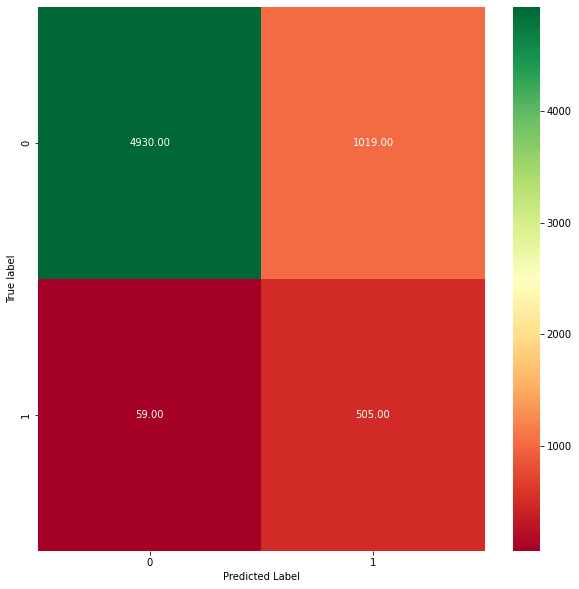

In [90]:
eval_clf_model(y_pred, y_test)

Interesting. Significantly boosted the Recall, but lowered the precision.  Basically this means the model mislabeled almost 70% of the positive instances (salary >50K), but was really good at labeling the negative instances (salary<=50K).

## Balancing the data
None of these algorithms have done a great job with prediction.  One of the problems may be that the data is significantly imbalanced. Only 24% of the instances are classed as salary>50K.  The algorithm seems to learn the negative cases (<=50K), but not the positive cases. Let's try to remedy this by randomly sampling the data negative instances to even up the classes.

In [96]:
df.salary.groupby(df.salary).count()

salary
0    24720
1     7841
Name: salary, dtype: int64

In [15]:
positive = df.query('salary==1')
negative = df.query('salary==0')

In [16]:
neg = negative.sample(7841)

In [17]:
balanced = pd.concat([neg,positive])

In [18]:
X = balanced.iloc[:,0:-1]
y = balanced[['salary']]

In [19]:
transformed_X = pd.get_dummies(X, columns=cat_attribs)
X_train, X_test, y_train, y_test = train_test_split(transformed_X,y, test_size=.20, random_state=32)

In [24]:
random_forest.fit(X_train,np.ravel(y_train))

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['age', 'fnlwgt',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week'])])),
                ('rf',
                 RandomForestClassifier(max_samples=5000, n_estimators=1000,
                                        n_jobs=-1))])

Precision:  0.8485037406483791
Recall: 0.8091557669441142
F1 Score: 0.8283627510651249


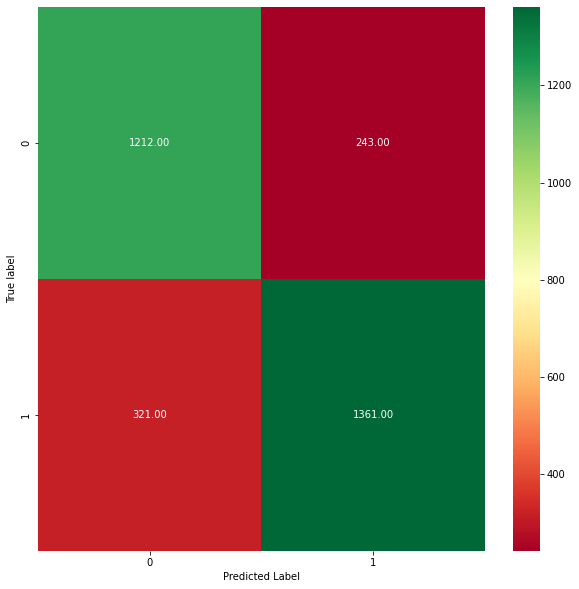

In [25]:
y_pred = random_forest.predict(X_test)
eval_clf_model(y_pred, y_test)

We actually got better results with this.  However, there is no free lunch. It is possible with random sampling that we lose important information that is included in the instances not selected for the sample. Therefore, you have to be careful with this.  Another more complicated method is to use minority class oversampling in which you make synthetic instances of the minority class.

## Another Example
Let's work with the bank data set we have used in the past with Logistic Regression.

In [28]:
df = pd.read_csv('/content/gdrive/MyDrive/CS430/bank-full.csv', sep=';')
df.rename(columns={"y": "outcome"}, inplace=True)
df['outcome'] = df['outcome'].apply(lambda x: 1 if x == "yes" else 0)  #If the value in the row is yes, recode to 1, otherwise recode to 0.

X = df.iloc[:,0:-1]
y = df[['outcome']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=32)

num_attribs = ['age','balance','day','duration','campaign','pdays','previous']
cat_attribs = ['job','marital','education','default','housing','loan','contact','month','poutcome']

In [30]:
col_transform = ColumnTransformer(transformers=[
                               ('cat',OneHotEncoder(), cat_attribs),
                               ('num',MinMaxScaler(), num_attribs),]
                  )

In [32]:
random_forest = Pipeline([
                     ('transform', col_transform),
                     ('rf',RandomForestClassifier(n_estimators=1000, max_samples=500, bootstrap=True))
                     ])

In [33]:
random_forest.fit(X_train,np.ravel(y_train))

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('num', MinMaxScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous'])])),
                ('rf',
                 RandomForestClassifier(max_samples=500, n_estimators=1000))])

Precision:  0.18471953578336556
Recall: 0.7100371747211895
F1 Score: 0.29316960859554875


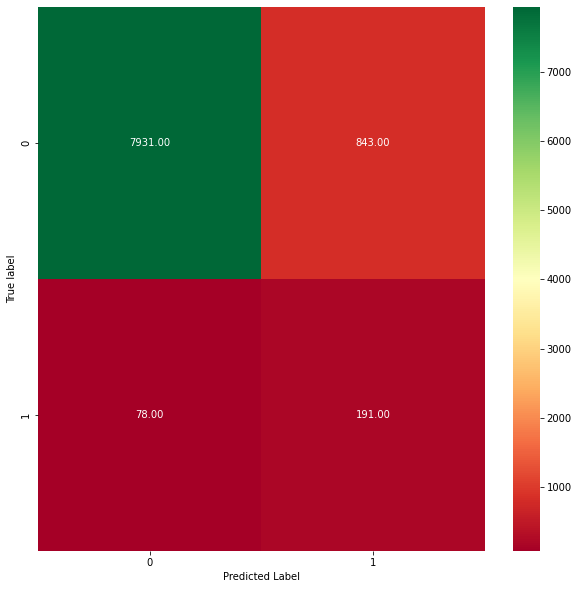

In [35]:
y_pred = random_forest.predict(X_test)
eval_clf_model(y_pred, y_test)

In [41]:
#names = random_forest[:-1].get_feature_names_out()
#for name, score in zip(names,random_forest.named_steps.rf.feature_importances_):
  #print(name, score)

In [37]:
df = pd.read_csv('/content/gdrive/MyDrive/CS430/breast_cancer_data.csv')

In [38]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [44]:
df.diagnosis.groupby(df.diagnosis).count()

diagnosis
B    357
M    212
Name: diagnosis, dtype: int64

In [48]:
df['diagnosis'] = df['diagnosis'].apply(lambda x: 1 if x == "B" else 0) 

In [49]:
X = df.iloc[:,1:-1]
y = df[['diagnosis']]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=32)

In [51]:
random_forest2 = Pipeline([
                     ('rf',RandomForestClassifier(n_estimators=1000, max_samples=100, bootstrap=True))
                     ])

In [53]:
random_forest2.fit(X_train,np.ravel(y_train))

Pipeline(steps=[('rf',
                 RandomForestClassifier(max_samples=100, n_estimators=1000))])

Precision:  1.0
Recall: 0.9859154929577465
F1 Score: 0.9929078014184397


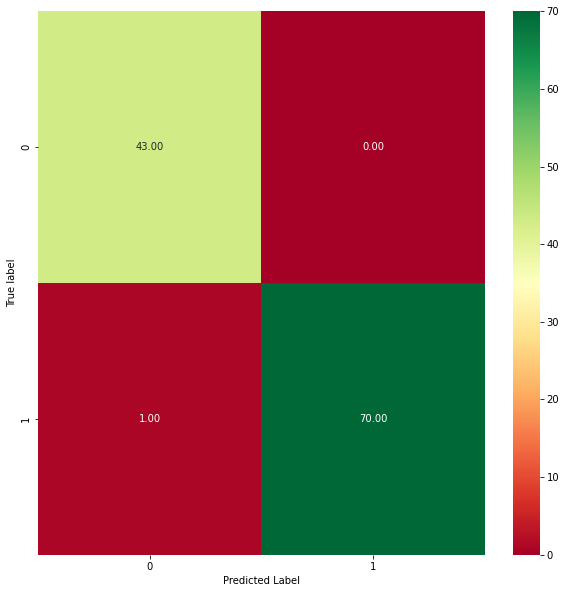

In [56]:
y_pred = random_forest2.predict(X_test)
eval_clf_model(y_pred, y_test)

In [70]:
red = pd.read_csv('/content/gdrive/MyDrive/CS430/winequality-red.csv', sep=';')
white = pd.read_csv('/content/gdrive/MyDrive/CS430/winequality-white.csv', sep=';')

In [74]:
df = pd.concat([red, white])

In [76]:
df.quality.groupby(df.quality).count()

quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64

In [82]:
X = df.iloc[:,0:-1]
y = df[['quality']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=32)

In [103]:
temp1 = pd.DataFrame(y_train,columns = ['quality'])
temp2 = pd.DataFrame(y_test,columns = ['quality'])

In [105]:
temp1.quality.groupby(temp1.quality).count()

quality
3      24
4     169
5    1722
6    2248
7     877
8     153
9       4
Name: quality, dtype: int64

In [106]:
temp2.quality.groupby(temp2.quality).count()

quality
3      6
4     47
5    416
6    588
7    202
8     40
9      1
Name: quality, dtype: int64

In [83]:
num_attribs = df.columns[0:-1]
col_transform = ColumnTransformer(transformers=[
                               ('num',MinMaxScaler(), num_attribs),]
                  )

In [84]:
random_forest3 = Pipeline([
                           ('transform', col_transform),
                           ('rf',RandomForestClassifier(n_estimators=1000, max_samples=100, bootstrap=True))
                     ])

In [85]:
random_forest3.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object'))])),
                ('rf',
                 RandomForestClassifier(max_samples=100, n_estimators=1000))])

In [86]:
y_pred = random_forest3.predict(X_test)

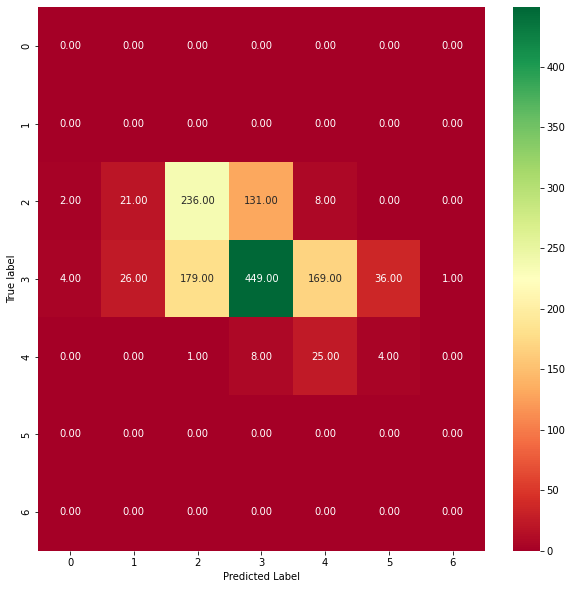

In [89]:
plot_cm(y_pred, y_test)

In [92]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.57      0.59      0.58       398
           6       0.76      0.52      0.62       864
           7       0.12      0.66      0.21        38
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.55      1300
   macro avg       0.21      0.25      0.20      1300
weighted avg       0.68      0.55      0.59      1300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
